<a href="https://colab.research.google.com/github/zyduan202/BASF_Project2_Codes/blob/main/Effects_with_different_random_states.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A. Data Preparation 

In [ ]:
# Importing the other libraries

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 7.6 MB/s eta 0:00:00


In [ ]:
# Importing the dataset
data = pd.read_excel('/content/sample_data/PNNL_data_FinalCurated.xlsx', sheet_name ='Initial set')

In [ ]:
X = data[["crystal radius",'Pauling Electronegativity','FE','OE',
          'valence s','valence p',"valence d",'valence f','specific heat',
          "thermal conductivity","Cohesive energy",
          "GHSV","H2CO","Temp"]]

y = data['F_STY']


In [ ]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 0)


# B. Hyperparameter tuning

## 1.Random Forest (model_RF2)

Changing the random state in the GridSearchCV process will change the random seed used for shuffling the data during training and for randomly initializing the weights of the model, if applicable. This can have several effects:

- The model performance may change: Since different random seeds will result in different splits of the data for training and validation, the performance of the model on the validation set may change.

- The optimal hyperparameters may change: GridSearchCV may find different optimal hyperparameters for the model based on the random seed used, as the optimal hyperparameters depend on the specific data splits used during training.

- Reproducibility may be affected: Changing the random seed will result in a different set of random numbers generated during training, which may affect the reproducibility of the results.

Therefore, it is important to report the random seed used when training a model and to test the stability of the model by training it with different random seeds and comparing the results.





### GridSearchCV and model fitting with optimized parameters

In [ ]:
#Grid search
from sklearn.model_selection import GridSearchCV

#Grid search for RF
model_RF1 = RandomForestRegressor(random_state = 0)

param_grid={'n_estimators':np.arange(100,1001,100).tolist(),
                'max_features':["sqrt"],
                'max_depth':[20,40,60,80],
                'min_samples_split':[2,4,6,8,10]}

tuning = GridSearchCV(estimator=model_RF1, 
                          param_grid = param_grid,
                          cv=5,
                          verbose=1,
                          n_jobs=-1)
    
tuning.fit(X_train, y_train)

print("Best parameters:")
print(tuning.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best parameters:
{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 300}


**random_state in fitting random forest**

When building a random forest model, several random choices are made that can affect the final model performance. For example, the algorithm randomly selects a subset of features to consider when splitting a node, and it also randomly samples the training data for each tree. By setting a value for random_state, you can ensure that the random choices made during the model building process are reproducible.

If you set a fixed value for random_state, you will get the same result every time you run the model with the same input data and settings. This can be useful when you need to compare different models or run experiments with the same conditions.

**random_state: int, RandomState instance or None, default=None**

Controls both the randomness of the bootstrapping of the samples used when building trees (if bootstrap=True) and the sampling of the features to consider when looking for the best split at each node (if max_features < n_features).

**model_RF1 vs. model_RF2**

1. model_1(random_state=0, par1=init1, par2=init2, par3=init3, par4=init4)

  GridSearchCV_1 with model_1 -> par3=best3, par4=best4 -> apply to model_2

  model_2(random_state=0, par1=init1, par2=init2, par3=best3, par4=best4)

2. model_3(random_state=1, par1=init11, par2=init22, par3=init33, par4=init44)

  GridSearchCV_2 with model_3 -> par3=best33, par4=best44 -> apply to model_4 & model_5

  model_4(random_state=0, par1=init1, par2=init2, par3=init33, par4=init44)

  model_5(random_state=1, par1=init11, par2=init22, par3=init33, par4=init44)

hyperparameters without grid_searc remain the same in model_RF1 and model_RF2

- change random_state in the GridSearchCV process, models with different initialization would be used for searching optimal hyperparameters. Therefore, the optimal hyperparameters would change accordingly. (best3 vs. best33)
- hyperparameters which are not optimized by GridSearchCV, retain the initial values, which is fixed by random_state

The training R2 is:  0.9712595824852647
The test R2 is:  0.9308061062583437
MSE: 27.18
RMSE of test set: 5.21
RMSE of train set: 3.48
The mean accuracy is:  0.7835729441683873


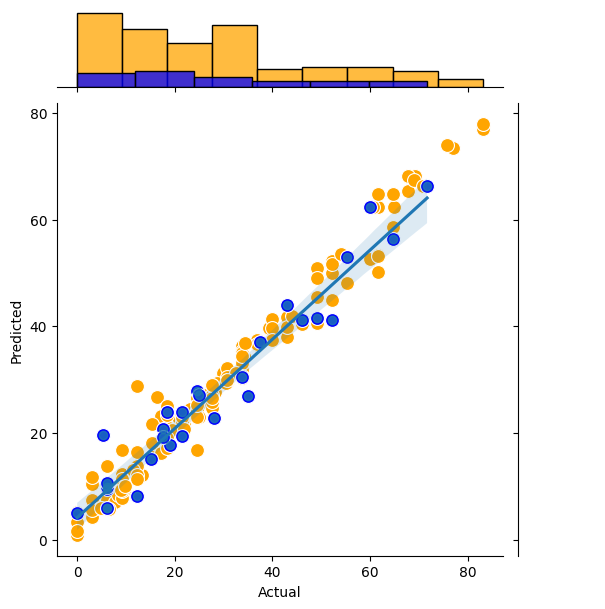

In [ ]:
# Fitting RandomForest Regression with optimized parameters

from sklearn.ensemble import RandomForestRegressor
model_RF2 =  RandomForestRegressor(max_depth = 20, max_features = 'sqrt', 
                   min_samples_split = 2, n_estimators = 300, random_state = 0)
model_RF2.fit(X_train, y_train)


# Measure the R2 for training and test set
model_score = model_RF2.score(X_train,y_train)
print("The training R2 is: ", model_RF2.score(X_train, y_train))
print("The test R2 is: ", model_RF2.score(X_test, y_test))


# The mean squared error & Variance
from sklearn.metrics import mean_squared_error
from math import sqrt

y_predicted = model_RF2.predict(X_test)
y_predicted_train = model_RF2.predict(X_train)

print("MSE: %.2f"% mean_squared_error(y_test, y_predicted))
print("RMSE of test set: %.2f"% sqrt(mean_squared_error(y_test, y_predicted)))
print("RMSE of train set: %.2f"% sqrt(mean_squared_error(y_train, y_predicted_train)))


# K-cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = model_RF2, X = X_train, y= y_train, cv=5)
print("The mean accuracy is: ", accuracies.mean())

# Plotting the joint plot of  actual v/s predicted
pp_tr = model_RF2.predict(X_train)

from sklearn.metrics import mean_squared_error, r2_score
g = sns.JointGrid()
sns.scatterplot(x=y_train, y=pp_tr, s=100, color='orange', ax=g.ax_joint)
sns.scatterplot(x=y_test, y=y_predicted, s=100, color='blue', ax=g.ax_joint)
sns.regplot(x=y_test, y=y_predicted, ax=g.ax_joint)

g.set_axis_labels("Actual", "Predicted")
sns.histplot(x=y_train,ax=g.ax_marg_x, color ='orange')
sns.histplot(x=y_test, ax=g.ax_marg_x, color ='blue')

plt.locator_params(tight=None, nbins=5)
plt.show()

### SHAP value and CI

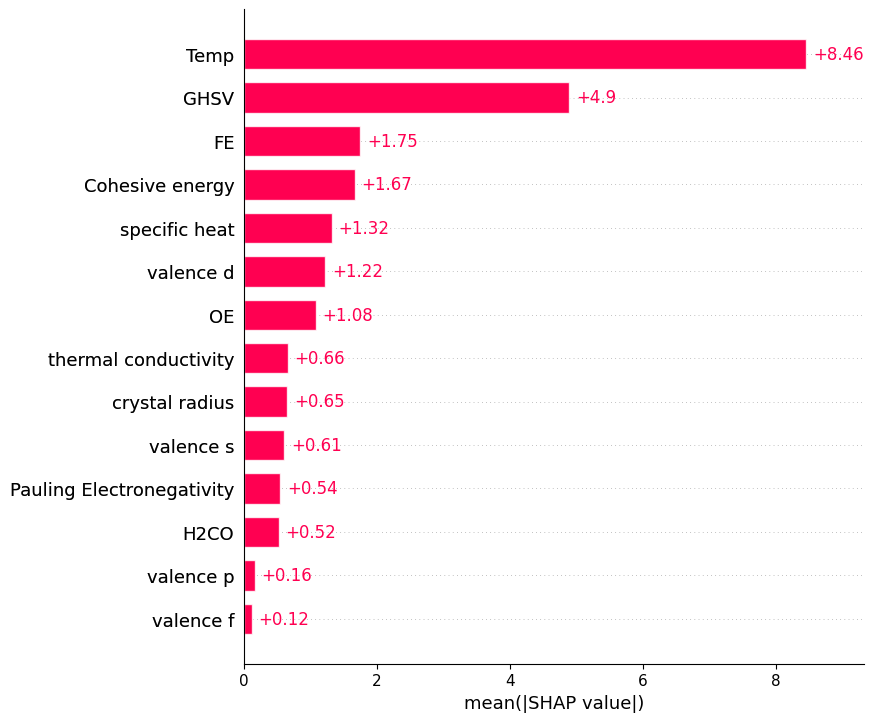

In [ ]:
def plot_SHAP (X, model):
  import shap
  explainer = shap.Explainer(model)
  shap_values = explainer(X)
  shap.plots.bar(shap_values, max_display=15)

plot_SHAP(X_train, model_RF2)

**Confidence interval for model_RF2 based on bootstrap**

With max_depth = 20, max_features = 'sqrt', min_samples_split = 2, n_estimators = 300, and random_state = 0


Percentiles can be used to construct confidence intervals when the distribution of the data is non-normal or unknown. In such cases, the standard formula for constructing confidence intervals based on the normal distribution may not be appropriate, and percentiles of the bootstrap distribution can provide a more accurate estimate of the confidence interval.

In [ ]:
## Funtions for Confidence interval

## Creat Boostrap samples
def bootstrap_samples(X, n_samples):
    bootstrap_samples = []

    for j in range(n_samples):
        np.random.seed(j)
        indices = np.random.choice(len(X), size=len(X), replace=True)
        sampled_data = X.iloc[indices, :]
        bootstrap_samples.append(sampled_data)

    return bootstrap_samples

## Calculate CI
def Confidence_interval(confidence_level, samples, trained_model):
  shapley = pd.DataFrame(np.zeros((len(samples), 14)))
  CI_df  = pd.DataFrame(np.zeros((14, 2)))

  explainer = shap.Explainer(trained_model)
  lower_percentile = (1 - confidence_level) / 2 * 100
  upper_percentile = (1 + confidence_level) / 2 * 100

  for i in range(len(samples)):
    shap_values = explainer(samples[i])
    shapley.iloc[i,] = abs(pd.DataFrame(shap_values.values)).mean()

  for j in range(14):
    CI_df.iloc[j,0] = np.percentile(shapley[j], 2.5)
    CI_df.iloc[j,1] = np.percentile(shapley[j], 97.5)

  CI_df.columns = ['Lower_Bound', 'Upper_Bound']
  CI_df['Interval_len'] = CI_df['Upper_Bound'] - CI_df['Lower_Bound']
  CI_df['Mean'] = shapley.mean()
  CI_df['Names'] = list(samples[0].columns)
  return CI_df.sort_values(by='Mean', ascending=False), shapley

## Plot CI  
def Plotting_CI(df):
  fig, ax = plt.subplots(figsize=(15,7))
  ax.errorbar(x=df["Mean"],
            y=np.arange(14),
            xerr=np.array(df['Interval_len']) ,
            fmt='o', capsize=5, color='black')
  plt.yticks(np.arange(14), df['Names'])
  ax.set_ylim(ax.get_ylim()[::-1])
  plt.xlabel('SHAP Value CI')
  plt.ylabel('Variable Name')
  plt.rc('font', size=13)
  plt.show()

In [ ]:
sample_train = bootstrap_samples(X_train,1000)
df1, df2 = Confidence_interval(confidence_level=0.95, samples = sample_train, trained_model = model_RF2)

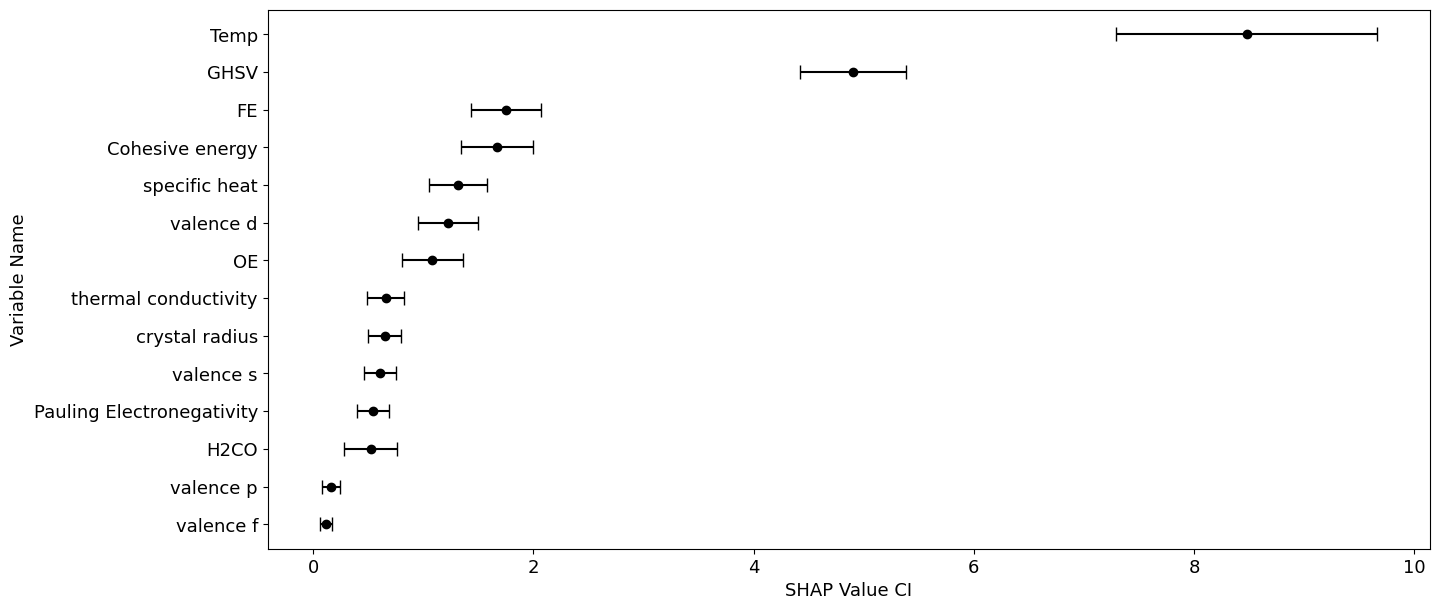

In [ ]:
Plotting_CI(df1)

In [ ]:
## Confidence interval for RF(shap values)
df1

In [ ]:
df1.to_csv('CI_RF.csv', index=False)

# Remember to change name for each variation!

### Effects of different random seeds of GridSearchCV (results_RF1)

**DO NOT RUN**

In [ ]:
##################
### DO NOT RUN ###
##################
# Codes in original paper

# Measure the R2 for training and test set
model_score = model_RF2.score(X_train,y_train)
print("The training R2 is: ", model_RF2.score(X_train, y_train))
print("The test R2 is: ", model_RF2.score(X_test, y_test))

# The mean squared error & Variance
from sklearn.metrics import mean_squared_error
from math import sqrt
y_predicted = model_RF2.predict(X_test)
y_predicted_train = model_RF2.predict(X_train)
print("MSE: %.2f"% mean_squared_error(y_test, y_predicted))
print("RMSE of test set: %.2f"% sqrt(mean_squared_error(y_test, y_predicted)))
print("RMSE of train set: %.2f"% sqrt(mean_squared_error(y_train, y_predicted_train)))

# K-cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = model_RF2, X = X_train, y= y_train, cv=5)
print("The mean accuracy is: ", accuracies.mean())


In [ ]:
# function for evaluating model performance with different random seeds

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

def evaluate_random_state(X, y, model_cls, param_grid, random_seeds):
    # Initialize arrays to store results
    best_params_list = []
    r2_scores_list = []
    train_rmse_list = []
    test_rmse_list = []
    cv_scores_list = []
    
    for seed in random_seeds:
        # Perform grid search with random seed
        model = model_cls(random_state=seed)
        
        # arguments in grid_search same as paper codes
        grid_search = GridSearchCV(estimator=model,  
                                   param_grid=param_grid,
                                   cv=5, 
                                   verbose=1,
                                   n_jobs=-1)
        grid_search.fit(X, y)
        
        # Calculate RMSE for the train set
        y_train_pred = grid_search.best_estimator_.predict(X)
        train_rmse = np.sqrt(mean_squared_error(y, y_train_pred))

        # Calculate RMSE for the test set
        y_test_pred = grid_search.best_estimator_.predict(X_test)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

        # Calculate R^2 for the train and test set
        train_r2 = r2_score(y, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        
        # Perform k-fold cross-validation
        cv_scores = cross_val_score(estimator=grid_search.best_estimator_, 
                                    X=X_train, 
                                    y=y_train, 
                                    cv=5)
        
        # Store best parameters, R^2 scores, RMSE scores, and cross-validation scores
        best_params_list.append(grid_search.best_params_)
        r2_scores_list.append({'train': train_r2, 'test': test_r2})
        train_rmse_list.append(train_rmse)
        test_rmse_list.append(test_rmse)
        cv_scores_list.append(cv_scores.mean())
    
    # Convert results to DataFrame
    results_df = pd.DataFrame({'random_seed': random_seeds, 
                               'best_params': best_params_list, 
                               'train_r2': [x['train'] for x in r2_scores_list],
                               'test_r2': [x['test'] for x in r2_scores_list],
                               'train_rmse': train_rmse_list,
                               'test_rmse': test_rmse_list,
                               'cv_scores': cv_scores_list})
    # Print the DataFrame
    print(results_df.to_string())

    return results_df

In [ ]:
# Compare 5 random seeds
param_grid={'n_estimators':np.arange(100,1001,100).tolist(),
            'max_features':["sqrt"],
            'max_depth':[20,40,60,80],
            'min_samples_split':[2,4,6,8,10]}
            
random_seeds = np.arange(1, 6)

results_RF1 = evaluate_random_state(X_train, y_train, RandomForestRegressor, param_grid, random_seeds)

# random_seeds = 0 -> 20, sqrt, 2, 300

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
   random_seed                                                                              best_params  train_r2   test_r2  train_rmse  test_rmse  cv_scores
0            1  {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 1000}  0.970991  0.931468    3.501095   5.188510   0.784011
1            2   {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 700}  0.971816  0.935738    3.450928   5.024300   0.783448
2            3   {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 900}  0.971096  0.933996    3.494743   5.091944   0.783281
3            4   {'max_depth': 20, 'max_features

,random_seed,best_params,train_r2,test_r2,train_rmse,test_rmse,cv_scores
0,1,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",0.970991,0.931468,3.501095,5.188510,0.784011
1,2,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",0.971816,0.935738,3.450928,5.024300,0.783448
2,3,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",0.971096,0.933996,3.494743,5.091944,0.783281
3,4,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",0.971428,0.927241,3.474648,5.346146,0.784167
4,5,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",0.972092,0.934910,3.434035,5.056548,0.780773


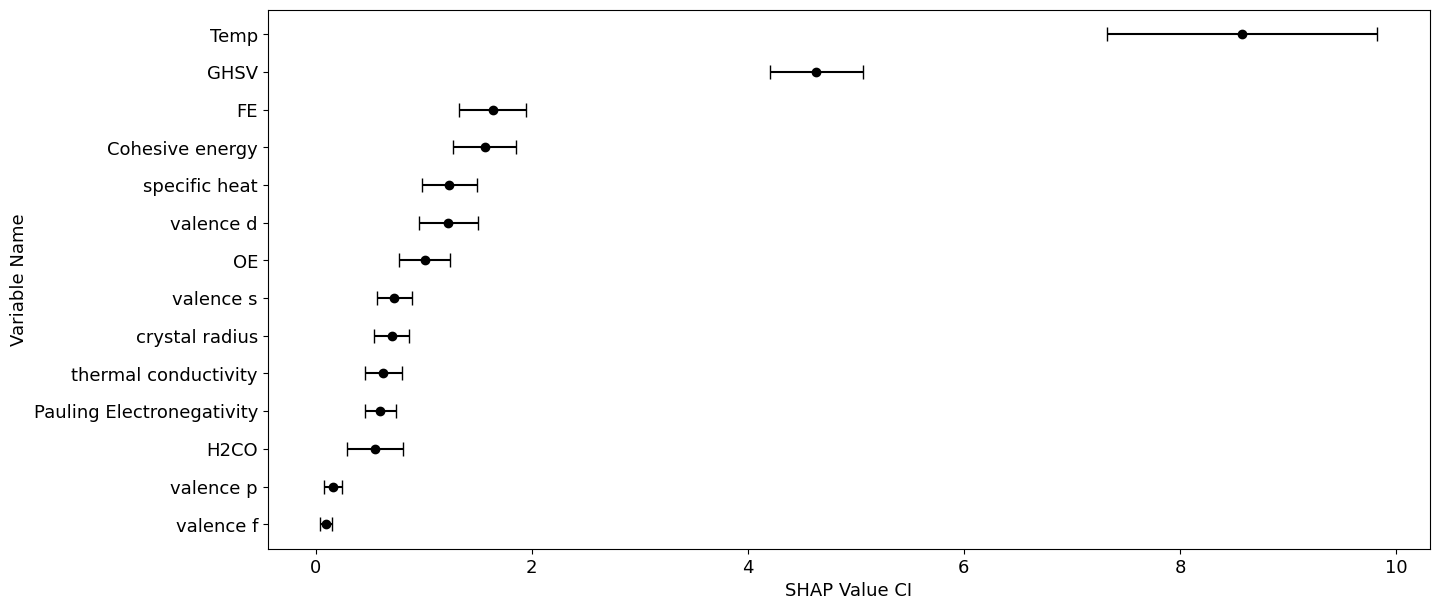

In [ ]:
# random seed = 0
# model_RF2 =  RandomForestRegressor(max_depth = 20, max_features = 'sqrt', 
#          min_samples_split = 2, n_estimators = 300, random_state = 0)

# random seed = 2
modelRFt_S2 =  RandomForestRegressor(max_depth = 20, max_features = 'sqrt', min_samples_split = 2, n_estimators = 700, random_state = 2)
modelRFt_S2.fit(X_train, y_train)

RFtS2_1, RFtS2_2 = Confidence_interval(confidence_level=0.95, samples = sample_train, trained_model = modelRFt_S2)
Plotting_CI(RFtS2_1)

RFtS2_1
RFtS2_1.to_csv('RFtS2_1.csv', index=False)


##  2.Gradient Boosting Regressor (model_GBR2)

### GridSearchCV and model fitting with optimized parameters

In [ ]:
#Grid search for GBDT

model_GBR1 = GradientBoostingRegressor(random_state = 0)

param_grid = {'learning_rate':[0.1,0.15,0.2],
              'n_estimators':np.arange(100,1001,100).tolist(),
                 'max_depth':[2,4,6,8],
                 'min_samples_leaf':[1,2],
              }

tuning = GridSearchCV(estimator=model_GBR1, 
                          param_grid = param_grid,
                          cv=5,
                          verbose=1,
                          n_jobs=-1)
    
tuning.fit(X_train, y_train)

print("Best parameters:")
print(tuning.best_params_)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best parameters:
{'learning_rate': 0.2, 'max_depth': 4, 'min_samples_leaf': 1, 'n_estimators': 100}


**Random_state in fitting GBR**

The random_state parameter in the GradientBoostingRegressor() function in Python is used to set the seed for the random number generator.

When building a **gradient boosting model**, several** random choices** are made that can affect the final model performance. For example, the algorithm **randomly selects a subset of features to consider when splitting a node**, and it also  **randomly samples the training data for each tree**. By setting a value for random_state, you can ensure that the random choices made during the model building process are reproducible.


**random_state: int, RandomState instance or None, default=None**

Controls the random seed given to each Tree estimator at each boosting iteration. In addition, it controls the random permutation of the features at each split (see Notes for more details). It also controls the random splitting of the training data to obtain a validation set if n_iter_no_change is not None. Pass an int for reproducible output across multiple function calls.

The training R2 is: 0.997
The test R2 is: 0.952 
MSE: 18.97
RMSE of test set: 4.36
RMSE of train set: 1.17
The mean accuracy is:  0.834277473648201


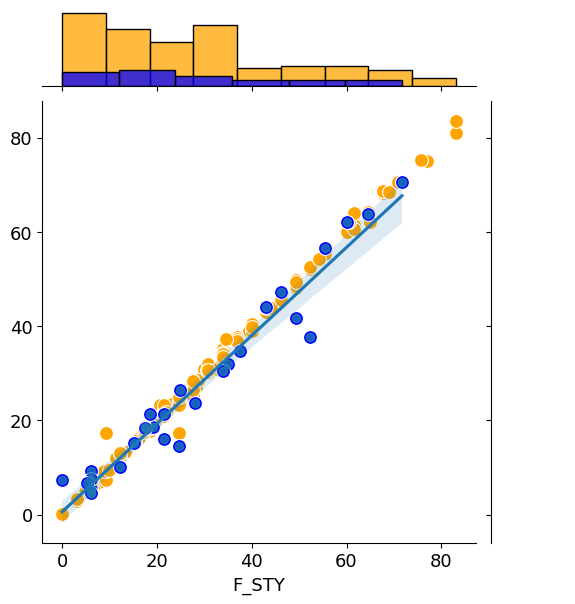

In [ ]:
# Fitting GBDT Regression to training data
from sklearn.ensemble import GradientBoostingRegressor
model_GBR2 =  GradientBoostingRegressor(learning_rate = 0.2, max_depth = 4, 
                      min_samples_leaf = 1, n_estimators = 100, random_state = 0)

model_GBR2.fit(X_train, y_train)

# Measure the R2 for training and test set
model_score = model_GBR2.score(X_train,y_train)
print("The training R2 is: %.3f" % model_GBR2.score(X_train, y_train))
print("The test R2 is: %.3f "% model_GBR2.score(X_test, y_test))



# The mean squared error & Variance
from sklearn.metrics import mean_squared_error
from math import sqrt

y_predicted = model_GBR2.predict(X_test)
y_predicted_train = model_GBR2.predict(X_train)

print("MSE: %.2f"% mean_squared_error(y_test, y_predicted))
print("RMSE of test set: %.2f"% sqrt(mean_squared_error(y_test, y_predicted)))
print("RMSE of train set: %.2f"% sqrt(mean_squared_error(y_train, y_predicted_train)))



# K-cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = model_GBR2, X = X_train, y= y_train, cv=5)
print("The mean accuracy is: ", accuracies.mean())



# Plotting the joint plot of  actual v/s predicted
pp_tr = model_GBR2.predict(X_train)

from sklearn.metrics import mean_squared_error, r2_score
g = sns.JointGrid()
sns.scatterplot(x=y_train, y=pp_tr, s=100, color='orange', ax=g.ax_joint)
sns.scatterplot(x=y_test, y=y_predicted, s=100, color='blue', ax=g.ax_joint)
sns.regplot(x=y_test, y=y_predicted, ax=g.ax_joint)

sns.histplot(x=y_train,ax=g.ax_marg_x, color ='orange')
sns.histplot(x=y_test, ax=g.ax_marg_x, color ='blue')

plt.locator_params(tight=None, nbins=5)
plt.show()

### SHAP value and CI

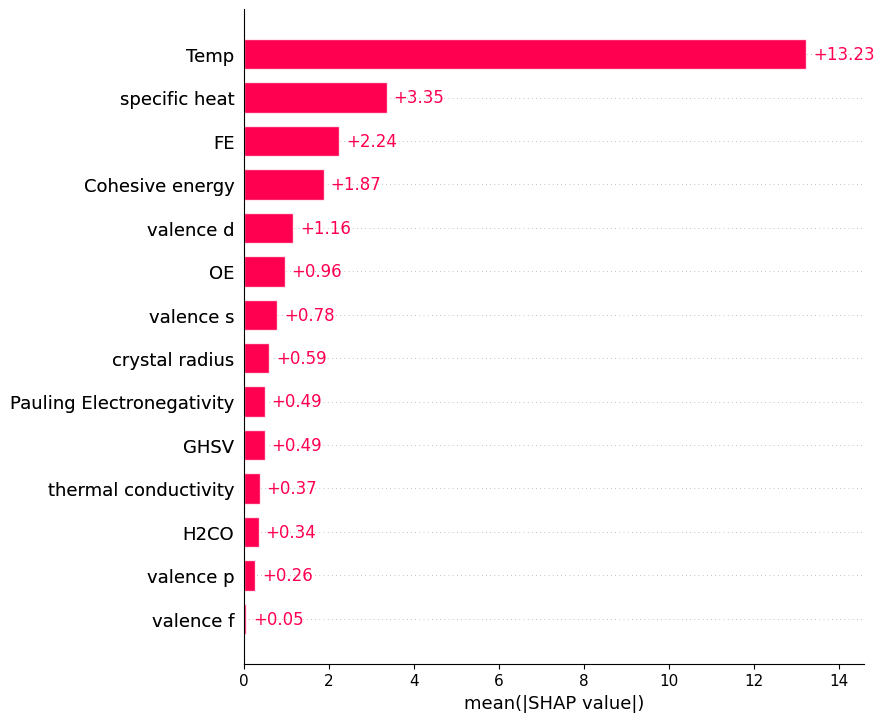

In [ ]:
import shap

explainer2 = shap.Explainer(model_GBR2)
shap_values2 = explainer2(X_train)
shap.plots.bar(shap_values2, max_display=15)

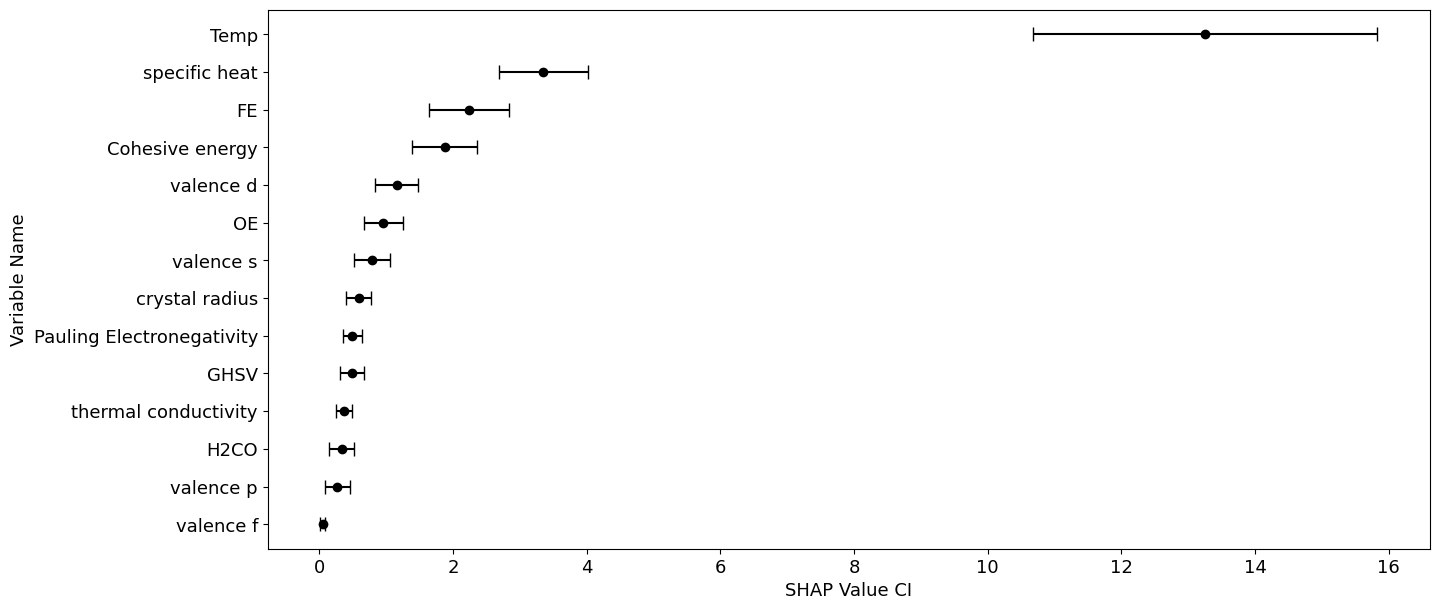

In [ ]:
df3, df4 = Confidence_interval(confidence_level=0.95, samples = sample_train, trained_model = model_GBR2)
Plotting_CI(df3)

In [ ]:
df3

,Lower_Bound,Upper_Bound,Interval_len,Mean,Names
13,11.781189,14.222241,2.441052,13.037504,Temp
8,3.067544,3.664362,0.596818,3.372362,specific heat
2,1.944545,2.468963,0.524418,2.211619,FE
10,1.620194,2.059939,0.439745,1.844258,Cohesive energy
6,1.054932,1.344203,0.289271,1.191480,valence d
3,0.825892,1.086975,0.261083,0.952811,OE
4,0.649416,0.895494,0.246078,0.767220,valence s
0,0.493818,0.674402,0.180584,0.578887,crystal radius
11,0.427165,0.583689,0.156524,0.502794,GHSV
1,0.432540,0.564593,0.132053,0.496840,Pauling Electronegativity


In [ ]:
df3.to_csv('CI_GBR.csv', index=False)
# Remember to change name for each variation

### Effects of different random seeds of GridSearchCV (results_GBR1)

In [ ]:
# Compare 5 random seeds
param_grid = {'learning_rate':[0.1,0.15,0.2],
              'n_estimators':np.arange(100,1001,100).tolist(),
                 'max_depth':[2,4,6,8],
                 'min_samples_leaf':[1,2],
              }
            
random_seeds = np.arange(1, 6)

results_GBR1 = evaluate_random_state(X_train, y_train, GradientBoostingRegressor, param_grid, random_seeds)


Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
   random_seed                                                                         best_params  train_r2   test_r2  train_rmse  test_rmse  cv_scores
0            1  {'learning_rate': 0.2, 'max_depth': 4, 'min_samples_leaf': 2, 'n_estimators': 100}  0.995420  0.947864    1.391100   4.525489   0.827373
1            2  {'learning_rate': 0.2, 'max_depth': 4, 'min_samples_leaf': 1, 'n_estimators': 100}  0.996738  0.953306    1.174018   4.282811   0.838815
2            3  {'learning_rate': 0.2, 'max_depth': 4, 'min_samples_leaf': 2, 'n_estimators': 100}  0.995420  0.947167    1.391100   4.555621   0.824843
3            4  {'learning_rate': 0.2, 'max_depth': 4, 'min_samples_

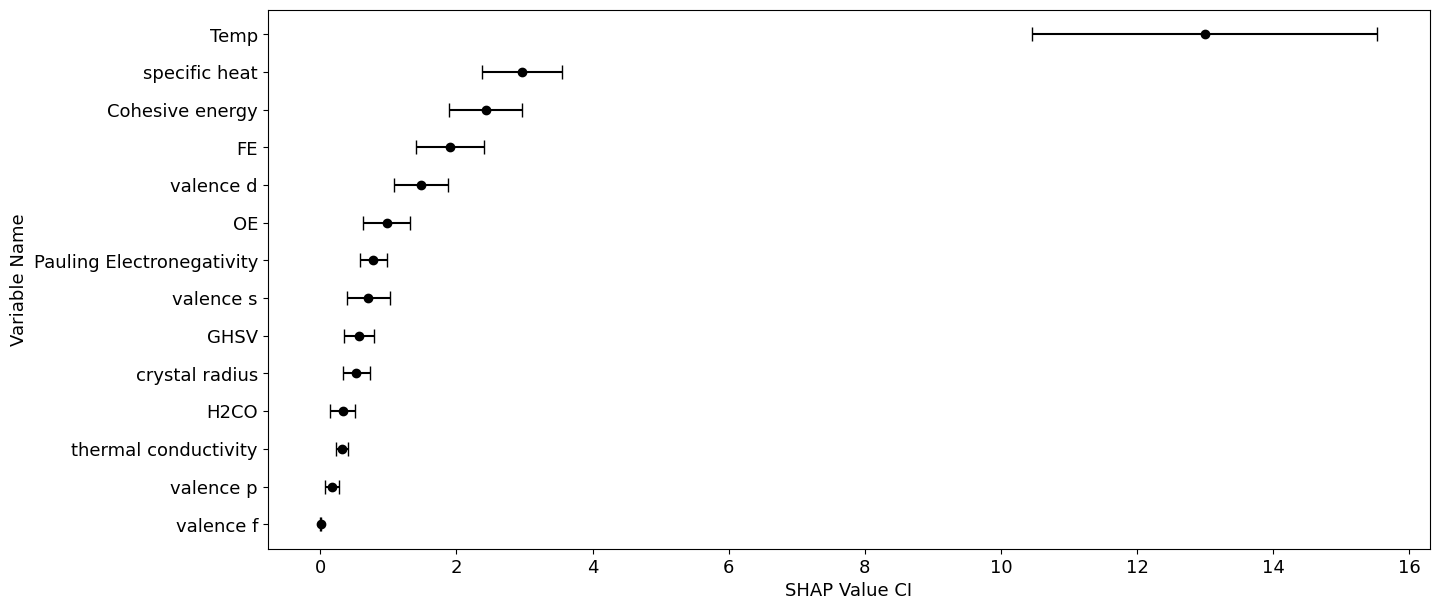

In [ ]:
# random seed = 0
# model_GBR2 =  GradientBoostingRegressor(learning_rate = 0.2, max_depth = 4, 
#                      min_samples_leaf = 1, n_estimators = 100, random_state = 0)

# random seed = 1
modelGBRs_S1 =  GradientBoostingRegressor(learning_rate = 0.2, max_depth = 4, 
                       min_samples_leaf = 2, n_estimators = 100, random_state = 1)
modelGBRs_S1.fit(X_train, y_train)

GBRtS1_1, GBRtS1_2 = Confidence_interval(confidence_level=0.95, samples = sample_train, trained_model = modelGBRs_S1)
Plotting_CI(GBRtS1_1)

GBRtS1_1.to_csv('GBRtS1_1.csv', index=False)


# C. Retrain on entire data 

## 1.Random Forest (model_full_RF)

### GridSearchCV and model fitting with optimized parameters

In [ ]:
#Grid search for RF

model = RandomForestRegressor(random_state = 0)

param_grid={'n_estimators':np.arange(100,1001,100).tolist(),
                'max_features':["sqrt"],
                'max_depth':[20,40,60,80],
                'min_samples_split':[2,4,6,8,10]}

tuning = GridSearchCV(estimator=model, 
                          param_grid = param_grid,
                          cv=5,
                          verbose=1,
                          n_jobs=-1)
    
tuning.fit(X, y)

print("Best parameters:")
print(tuning.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best parameters:
{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
# Fitting RandomForest Regression to the Training set

from sklearn.ensemble import RandomForestRegressor
model_full_RF =  RandomForestRegressor(max_depth = 20, max_features = 'sqrt', 
                    min_samples_split = 2, n_estimators = 100, random_state = 0)
model_full_RF.fit(X, y)


#Measure the R2 for training and test set
model_score = model_full_RF.score(X,y)
print("The training R2 is: ", model_full_RF.score(X, y))
#print("The test R2 is: ", model.score(X, y))


# The mean squared error & Variance
from sklearn.metrics import mean_squared_error
from math import sqrt

y_predicted_all = model_full_RF.predict(X)
print("MSE: %.2f"% mean_squared_error(y, y_predicted_all))
print("RMSE of train set: %.2f"% sqrt(mean_squared_error(y, y_predicted_all)))


# k-cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

scores = cross_validate(estimator = model_full_RF, X=X, y=y, cv=5, scoring=('r2'), return_train_score=True)
accuracies = cross_val_score(estimator = model_full_RF, X = X, y= y, cv=5)
#print("The mean accuracy is: ", accuracies.mean())
# print(scores)
print("The mean accuracy is: ", accuracies.mean())
# accuracies

The training R2 is:  0.9764954663090588
MSE: 9.83
RMSE of train set: 3.13
The mean accuracy is:  0.5561851406777804


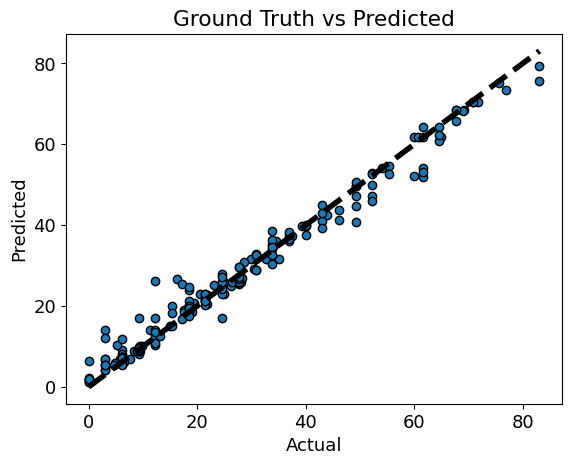

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y, y_predicted_all, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Ground Truth vs Predicted")
plt.show()

### SHAP values and CI

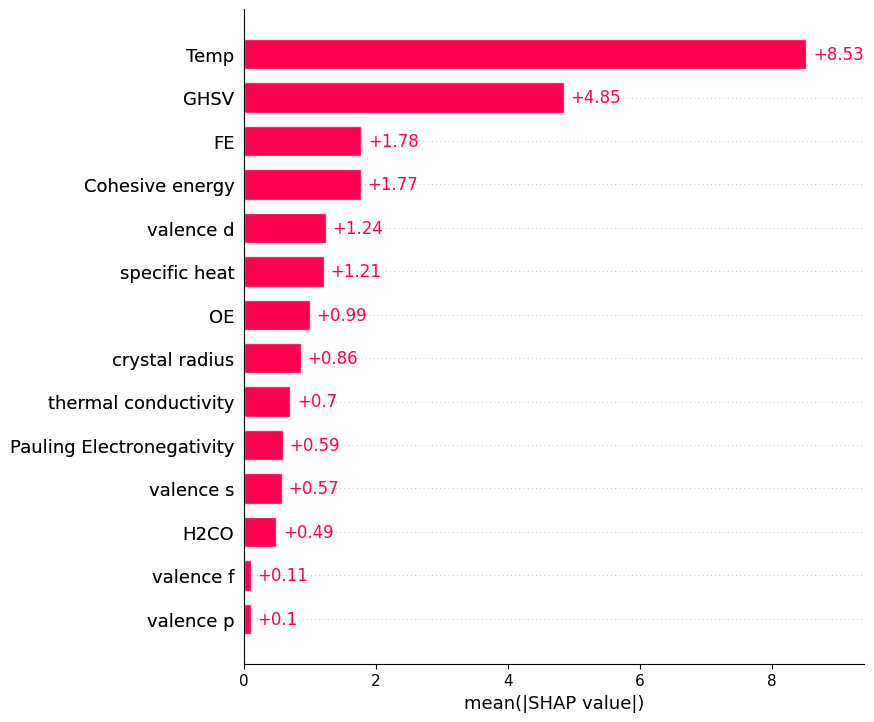

In [ ]:
import shap

explainer = shap.Explainer(model_full_RF)
shap_values = explainer(X)

shap.plots.bar(shap_values, max_display=15)

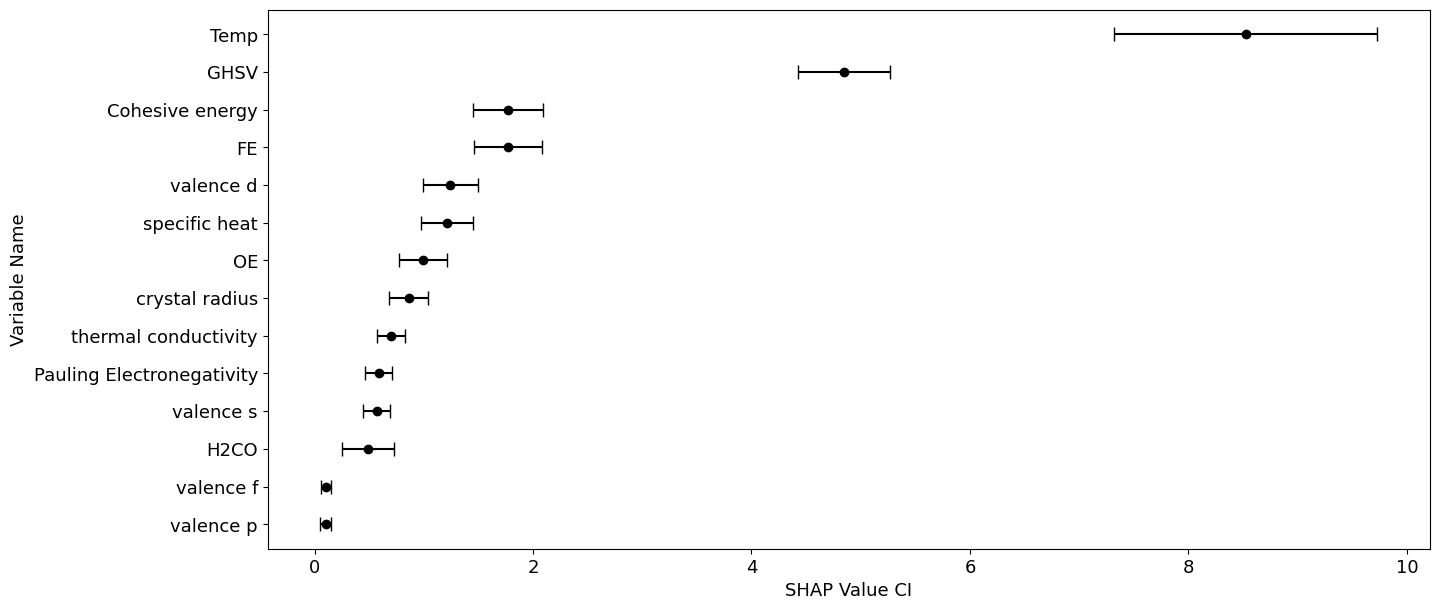

In [ ]:
sample = bootstrap_samples(X,1000)
df5, df6 = Confidence_interval(confidence_level=0.95, samples = sample, trained_model = model_full_RF)
Plotting_CI(df5)

In [ ]:
df5

,Lower_Bound,Upper_Bound,Interval_len,Mean,Names
13,7.918075,9.121391,1.203316,8.525817,Temp
11,4.637280,5.055397,0.418117,4.846337,GHSV
10,1.613943,1.933811,0.319868,1.772513,Cohesive energy
2,1.621669,1.929490,0.307820,1.771573,FE
6,1.116299,1.367858,0.251559,1.243979,valence d
8,1.098418,1.337405,0.238988,1.211483,specific heat
3,0.879120,1.096381,0.217261,0.992195,OE
0,0.777058,0.956014,0.178956,0.864267,crystal radius
9,0.636210,0.762981,0.126771,0.698527,thermal conductivity
1,0.524769,0.650122,0.125353,0.587333,Pauling Electronegativity


In [ ]:
df5.to_csv('CI_RF_FULL.csv', index=False)

### Effects of different random seeds of GridSearchCV (results_RF2)

In [ ]:
# Compare 5 random seeds
param_grid={'n_estimators':np.arange(100,1001,100).tolist(),
            'max_features':["sqrt"],
            'max_depth':[20,40,60,80],
            'min_samples_split':[2,4,6,8,10]}
            
random_seeds = np.arange(1, 6)

results_RF2 = evaluate_random_state(X, y, RandomForestRegressor, param_grid, random_seeds)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
   random_seed                                                                             best_params  train_r2   test_r2  train_rmse  test_rmse  cv_scores
0            1  {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 900}  0.976479  0.989848    3.135635   1.996975   0.783123
1            2  {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}  0.975593  0.988286    3.194147   2.145094   0.777031
2            3  {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 500}  0.977047  0.990408    3.097493   1.941108   0.779339
3            4  {'max_depth': 20, 'max_features': 's

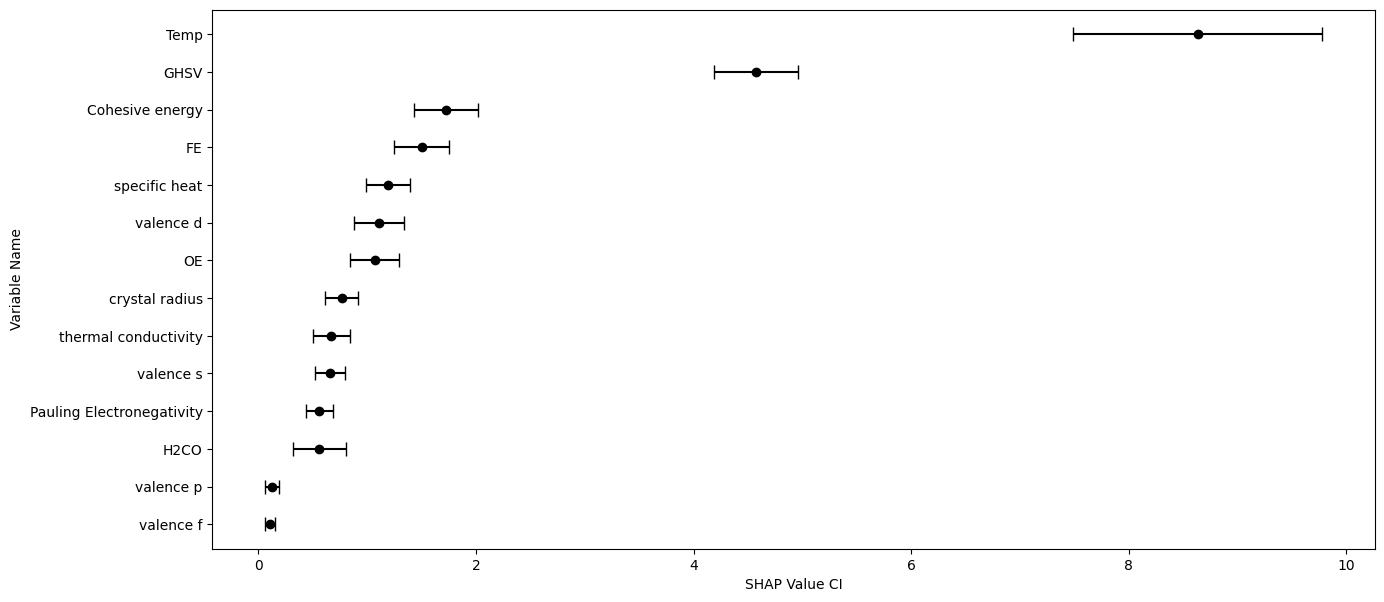

In [ ]:
# random seed = 0
# model_full_RF =  RandomForestRegressor(max_depth = 20, max_features = 'sqrt', 
#      min_samples_split = 2, n_estimators = 100, random_state = 0)


# random seed = 3
modelRFf_S3 =  RandomForestRegressor(max_depth = 20, max_features = 'sqrt', min_samples_split = 2, n_estimators = 500, random_state = 3)
modelRFf_S3.fit(X_train, y_train)

import shap
Sample = bootstrap_samples(X,1000)
RFfS3_1, RFfS3_2 = Confidence_interval(confidence_level=0.95, samples = Sample, trained_model = modelRFf_S3)
Plotting_CI(RFfS3_1)

RFfS3_1
RFfS3_1.to_csv('RFfS3_1.csv', index=False)

## 2.Gradient Boosting Regressor (model_full_GBR)

### GridSearchCV and model fitting with optimized parameters

In [ ]:
#Grid search for GBDT

model_full = GradientBoostingRegressor(random_state = 0)

param_grid = {'learning_rate':[0.1,0.15,0.2],
              'n_estimators':np.arange(100,1001,100).tolist(),
                 'max_depth':[2,4,6,8],
                 'min_samples_leaf':[1,2],
                 }

tuning = GridSearchCV(estimator=model_full, 
                          param_grid = param_grid,
                          cv=5,
                          verbose=1,
                          n_jobs=-1)
    
tuning.fit(X, y)

print("Best parameters:")
print(tuning.best_params_)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best parameters:
{'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 2, 'n_estimators': 100}


In [ ]:
# Fitting GBDT Regression to entire data

model_full_GBR =  GradientBoostingRegressor(learning_rate = 0.1, max_depth = 6, 
                      min_samples_leaf = 2, n_estimators = 100, random_state = 0)
model_full_GBR.fit(X, y)


#Measure the R2 for training and test set
model_score = model_full_GBR.score(X,y)
print("The training R2 is: ", model_full_GBR.score(X, y))
#print("The test R2 is: ", model.score(X, y))

# The mean squared error & Variance
from sklearn.metrics import mean_squared_error
from math import sqrt
y_predicted_all = model_full_GBR.predict(X)
print("MSE: %.2f"% mean_squared_error(y, y_predicted_all))
print("RMSE of train set: %.2f"% sqrt(mean_squared_error(y, y_predicted_all)))


# K-cross validation
scores = cross_validate(estimator = model_full_GBR, X=X, y=y, cv=5, scoring=('r2'), return_train_score=True)
accuracies = cross_val_score(estimator = model_full_GBR, X = X, y= y, cv=5)
#print("The mean accuracy is: ", accuracies.mean())
# print(scores)
print("The mean accuracy is: ", accuracies.mean())
# accuracies

The training R2 is:  0.9969288421011417
MSE: 1.28
RMSE of train set: 1.13
{'fit_time': array([0.10218763, 0.09642053, 0.10146117, 0.08889794, 0.07927513]), 'score_time': array([0.00277209, 0.0027647 , 0.00257277, 0.00377917, 0.00287342]), 'test_score': array([ 0.58399215,  0.88330761,  0.86828935,  0.35989506, -0.21399461]), 'train_score': array([0.99667601, 0.98684722, 0.99645677, 0.99703121, 0.99867246])}


The mean accuracy is:  0.49629791163137427


array([ 0.58399215,  0.88330761,  0.86828935,  0.35989506, -0.21399461])

### SHAP value and CI

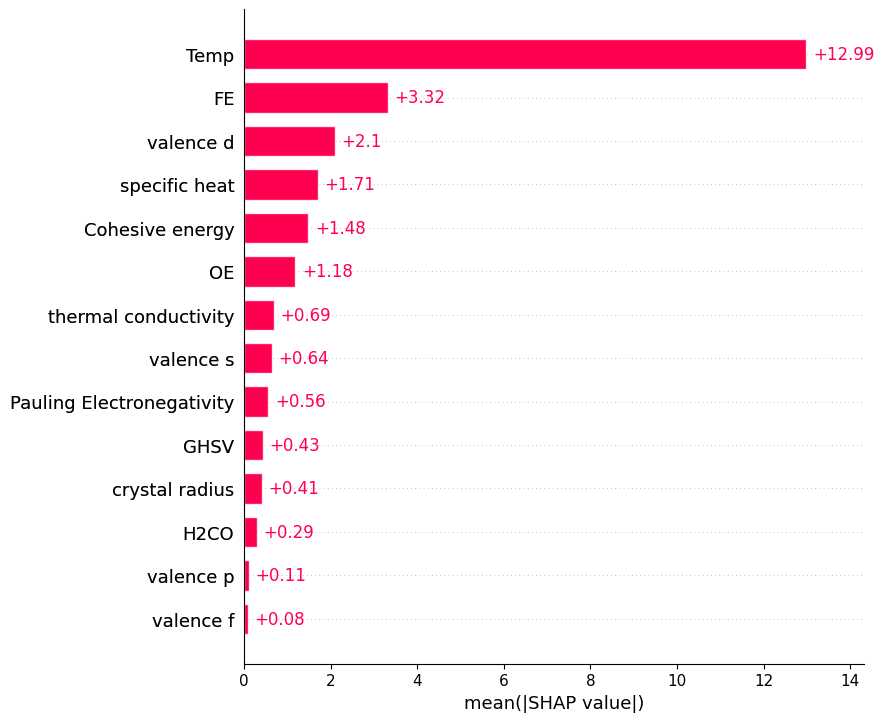

In [ ]:
import shap

explainer = shap.Explainer(model_full_GBR)
shap_values = explainer(X)

shap.plots.bar(shap_values, max_display=15)

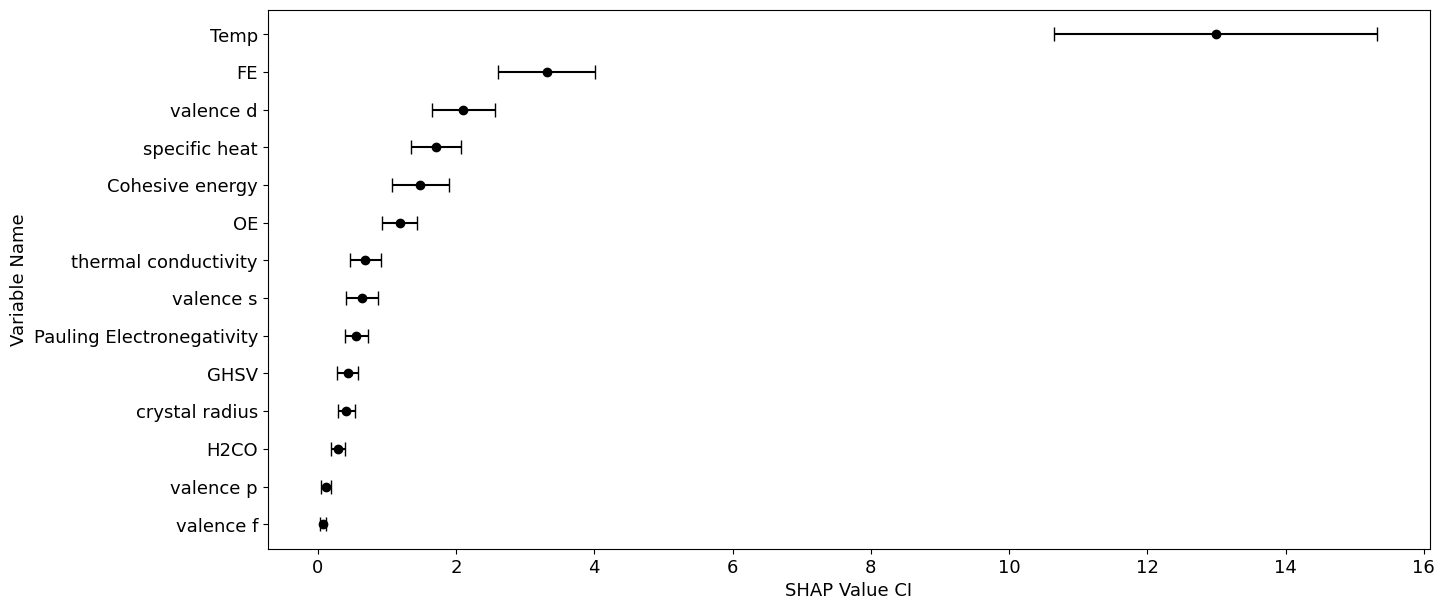

In [ ]:
df7, df8 = Confidence_interval(confidence_level=0.95, samples = Sample, trained_model = model_full_GBR)
Plotting_CI(df7)

In [ ]:
df7

,Lower_Bound,Upper_Bound,Interval_len,Mean,Names
13,11.789402,14.124269,2.334867,12.992157,Temp
2,2.954782,3.661360,0.706578,3.311007,FE
6,1.875971,2.334796,0.458825,2.105492,valence d
8,1.529199,1.891125,0.361925,1.706455,specific heat
10,1.279065,1.692614,0.413549,1.482812,Cohesive energy
3,1.061419,1.311207,0.249788,1.183856,OE
9,0.575928,0.799957,0.224030,0.685305,thermal conductivity
4,0.526718,0.762996,0.236278,0.639081,valence s
1,0.478426,0.645097,0.166671,0.558591,Pauling Electronegativity
11,0.366388,0.514823,0.148435,0.434618,GHSV


In [ ]:
df7.to_csv('CI_GBR_FULL.csv', index=False)

### Effects of different random seeds of GridSearchCV

In [ ]:
# Test 1 random seed
param_grid = {'learning_rate':[0.1,0.15,0.2],
              'n_estimators':np.arange(100,1001,100).tolist(),
                 'max_depth':[2,4,6,8],
                 'min_samples_leaf':[1,2],
              }

random_seeds = np.arange(1, 2)

results_df4 = evaluate_random_state(X, y, GradientBoostingRegressor, param_grid, random_seeds)

results_df4

# The training R2 is:  0.9969288421011417
# MSE: 1.28
# RMSE of train set: 1.13
# The mean accuracy is:  0.49629791163137427
# array([ 0.58399215,  0.88330761,  0.86828935,  0.35989506, -0.21399461])

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


,random_seed,best_params,train_r2,test_r2,train_rmse,test_rmse,cv_scores
0,1,"{'learning_rate': 0.1, 'max_depth': 6, 'min_sa...",0.996929,0.998103,1.133038,0.863227,0.797213


In [ ]:
# Compare 5 random seeds
param_grid = {'learning_rate':[0.1,0.15,0.2],
              'n_estimators':np.arange(100,1001,100).tolist(),
                 'max_depth':[2,4,6,8],
                 'min_samples_leaf':[1,2],
              }
            
random_seeds = np.arange(1, 6)

results_GBR2 = evaluate_random_state(X, y, GradientBoostingRegressor, param_grid, random_seeds)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
   random_seed                                                                         best_params  train_r2   test_r2  train_rmse  test_rmse  cv_scores
0            1  {'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 2, 'n_estimators': 100}  0.996929  0.998103    1.133038   0.863227   0.797213
1            2  {'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 2, 'n_estimators': 100}  0.996929  0.998103    1.133038   0.863227   0.797932
2            3  {'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 2, 'n_estimators': 100}  0.996929  0.998103    1.133038   0.863227   0.798929
3            4  {'learning_rate': 0.1, 'max_depth': 6, 'min_samples_

# Partial Dependence

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.


(255.0, 400.0)

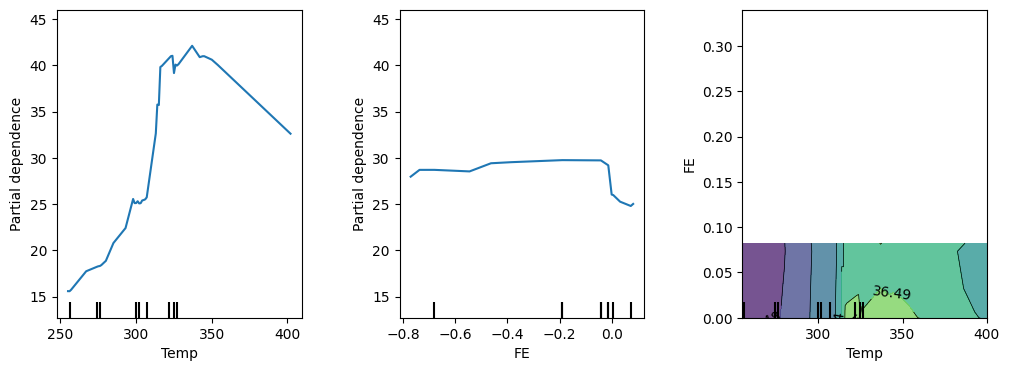

In [ ]:
features = ['Temp', 'FE', ('Temp', 'FE')]
_,ax = plt.subplots(ncols=3,figsize=(12,4))
display=PartialDependenceDisplay.from_estimator(model_full, X, features,ax=ax)
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

plt.ylim(0, 0.34,0.085)
plt.xlim(255,400)
#plt.savefig("PDP11.svg",dpi=600)

Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.


(255.0, 400.0)

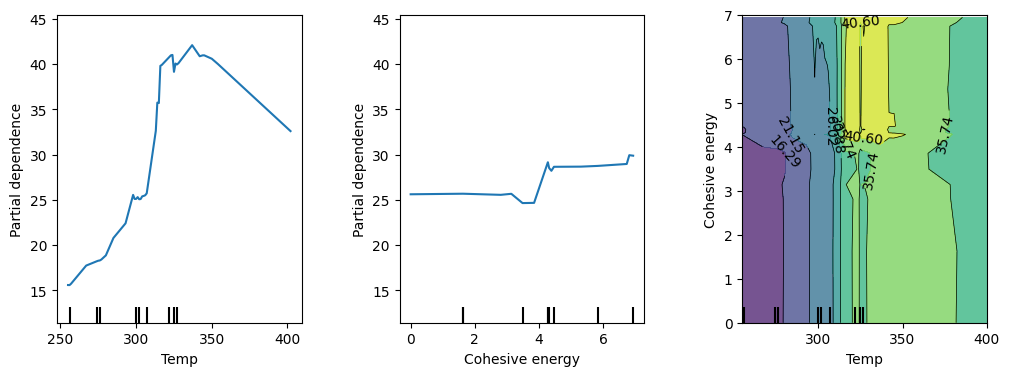

In [ ]:
features = ['Temp', 'Cohesive energy', ('Temp', 'Cohesive energy')]
_,ax = plt.subplots(ncols=3,figsize=(12,4))
display=PartialDependenceDisplay.from_estimator(model_full, X, features,ax=ax)
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

plt.ylim(0, 7,1)
plt.xlim(255,400)
#plt.savefig("PDP11.svg",dpi=600)

Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.


(3300.0, 15000.0)

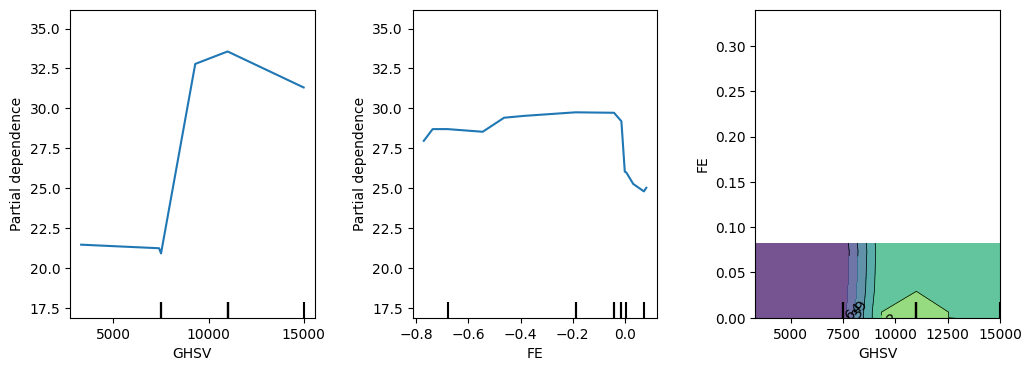

In [ ]:
features = ['GHSV', 'FE', ('GHSV', 'FE')]
_,ax = plt.subplots(ncols=3,figsize=(12,4))
display=PartialDependenceDisplay.from_estimator(model_full, X, features,ax=ax)
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

plt.ylim(0, 0.34,0.085)
plt.xlim(3300,15000)
#plt.savefig("PDP11.svg",dpi=600)

Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.


(3300.0, 15000.0)

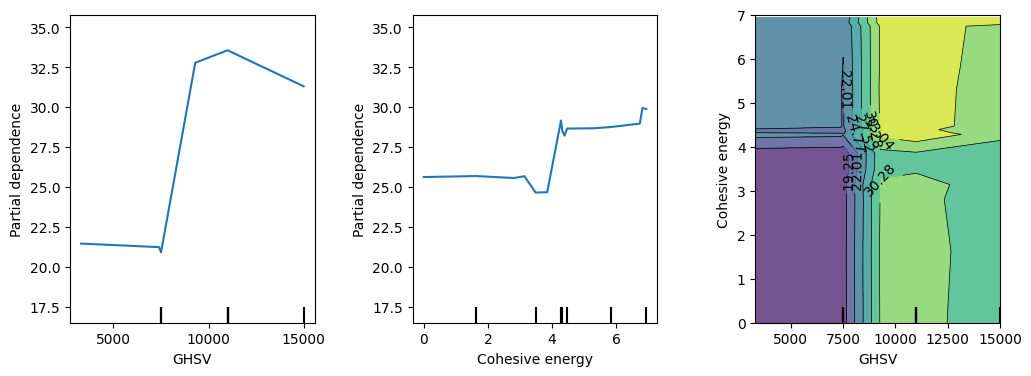

In [ ]:
features = ['GHSV', 'Cohesive energy', ('GHSV', 'Cohesive energy')]
_,ax = plt.subplots(ncols=3,figsize=(12,4))
display=PartialDependenceDisplay.from_estimator(model_full, X, features,ax=ax)
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

plt.ylim(0, 7,1)
plt.xlim(3300,15000)
#plt.savefig("PDP11.svg",dpi=600)

Passing the emit parameter of set_xlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.


(0.0, 7.0)

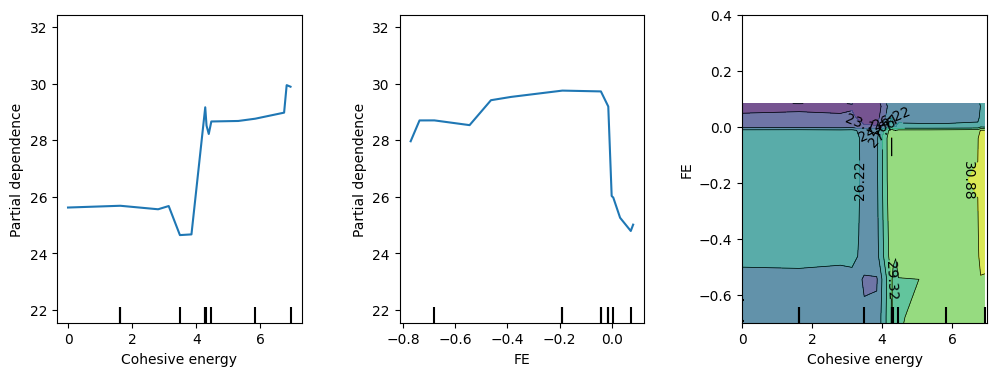

In [ ]:
features = ['Cohesive energy', 'FE',('Cohesive energy', 'FE')]
_,ax = plt.subplots(ncols=3,figsize=(12,4))
display=PartialDependenceDisplay.from_estimator(model_full, X, features,ax=ax)
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)


plt.ylim(-0.7, 0.4)
plt.xlim(0, 7,1)
#plt.savefig("PDP11.svg",dpi=600)

# Extrapolating to 7 new promoters

In [ ]:
Expdata = pd.read_excel('PNNL data_redone_final test.xlsx', sheet_name ='Test promoters')

In [ ]:
Expdata.head()

,P1,FE,OE,Covalent Radius,ionic radius,crystal radius,Pauling Electronegativity,MB electonegativity,metallic valence,valence electrons,...,SC2+ Oxy,Smethane,SHC,STY,C2OXY_STY,TOT_X2OXY,F_STY,F_C2OXY,F_TOT,Alcohol Ratio
0,Ni,0.0702,-0.894,1.21,1.35,0.7,1.91,1.76,5.78,10,...,46.05,33.41,10.83,21,112,133,6.461538,34.461538,40.923077,0.187500
1,Ni,0.0702,-0.894,1.21,1.35,0.7,1.91,1.76,5.78,10,...,37.72,36.85,17.48,36,192,228,11.076923,59.076923,70.153846,0.187500
2,Ni,0.0702,-0.894,1.21,1.35,0.7,1.91,1.76,5.78,10,...,24.17,51.32,15.91,65,202,267,20.000000,62.153846,82.153846,0.321782
3,Ni,0.0702,-0.894,1.21,1.35,0.7,1.91,1.76,5.78,10,...,28.57,46.16,14.16,86,236,322,26.461538,72.615385,99.076923,0.364407
4,Ni,0.0702,-0.894,1.21,1.35,0.7,1.91,1.76,5.78,10,...,20.60,56.10,11.44,169,307,476,52.000000,94.461538,146.461538,0.550489


In [ ]:
len(Expdata)

41

In [ ]:
X1 = Expdata[["crystal radius",
          'Pauling Electronegativity','FE','OE',
          'valence s','valence p',"valence d",'valence f','specific heat',
          "thermal conductivity","Cohesive energy",
          "GHSV","H2CO","Temp"]]
y1 = Expdata['F_STY']


In [ ]:
X1.head()

,crystal radius,Pauling Electronegativity,FE,OE,valence s,valence p,valence d,valence f,specific heat,thermal conductivity,Cohesive energy,GHSV,H2CO,Temp
0,0.7,1.91,0.0702,-0.894,2,0,8,0,0.44,90.7,4.44,7500,1.8,256.0
1,0.7,1.91,0.0702,-0.894,2,0,8,0,0.44,90.7,4.44,7500,1.8,277.0
2,0.7,1.91,0.0702,-0.894,2,0,8,0,0.44,90.7,4.44,11000,1.8,300.0
3,0.7,1.91,0.0702,-0.894,2,0,8,0,0.44,90.7,4.44,11000,1.8,305.0
4,0.7,1.91,0.0702,-0.894,2,0,8,0,0.44,90.7,4.44,11000,1.8,325.0


In [ ]:
Exp_pred=model_RF2.predict(X1) #make prediction on lab experimental data

Pred_exp= pd.DataFrame(Exp_pred)
Pred_exp

,0
0,9.933333
1,14.205978
2,26.107692
3,26.716923
4,42.473846
5,23.357773
6,14.205978
7,9.933333
8,14.205978
9,26.107692


In [ ]:
# Erro metrics on experimental validation 
from sklearn.metrics import mean_absolute_error
print("The test R2 is: ", model_RF2.score(X1, y1))

print("RMSE of test set: %.2f"% sqrt(mean_squared_error(y1, Exp_pred)))


The test R2 is:  0.640748866536017
RMSE of test set: 7.67


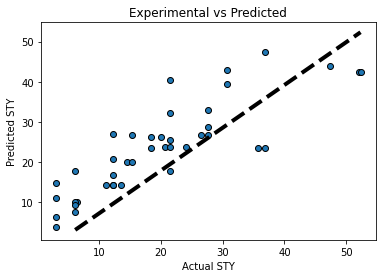

In [ ]:
#Plot the actual v/s predicted
fig, ax = plt.subplots()
ax.scatter(y1, Exp_pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y1.max()], [y1.min(), y1.max()], 'k--', lw=4)
ax.set_xlabel('Actual STY')
ax.set_ylabel('Predicted STY')
ax.set_title("Experimental vs Predicted")
plt.show()

In [ ]:
finalconcat= pd.concat([y1,Pred_exp.set_index(X1.index)], axis=1)
finalconcat.to_excel("STY_ExpvsPred_RF_with Ag.xlsx")

In [ ]:
Screendata = pd.read_excel('PNNL data_redone_final test.xlsx', sheet_name ='Nb')

In [ ]:
Screendata.head(10)

,P1,FE,OE,Covalent Radius,ionic radius,crystal radius,Pauling Electronegativity,MB electonegativity,metallic valence,valence electrons,...,SC2+ Oxy,Smethane,SHC,STY,C2OXY_STY,TOT_X2OXY,F_STY,F_C2OXY,F_TOT,Alcohol Ratio
0,B,-0.378,-0.890,0.82,0.85,0.25,2.04,1.76,5.78,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,B,-0.378,-0.890,0.82,0.85,0.25,2.04,1.76,5.78,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,B,-0.378,-0.890,0.82,0.85,0.25,2.04,1.76,5.78,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,B,-0.378,-0.890,0.82,0.85,0.25,2.04,1.76,5.78,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Nb,-0.401,-2.212,1.37,1.45,0.78,1.60,1.76,5.78,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Nb,-0.401,-2.212,1.37,1.45,0.78,1.60,1.76,5.78,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Nb,-0.401,-2.212,1.37,1.45,0.78,1.60,1.76,5.78,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Nb,-0.401,-2.212,1.37,1.45,0.78,1.60,1.76,5.78,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
XS = Screendata[["crystal radius",
          'Pauling Electronegativity','FE','OE',
          'valence s','valence p',"valence d",'valence f','specific heat',
          "thermal conductivity","Cohesive energy",
          "GHSV","H2CO","Temp"]]


In [ ]:
Screen_pred=model_RF2.predict(XS) #make prediction on B amd Nb

Pred_Screen= pd.DataFrame(Screen_pred)
Pred_Screen

,0
0,9.723077
1,11.839106
2,24.627692
3,36.584872
4,20.056410
5,25.603565
6,33.701538
7,35.781538
